In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
import random
from PIL import Image
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import pandas as pd
import cv2
import os
import ntpath
from matplotlib import image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa


In [3]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

def load_steering_img(data_dir, df):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = data.iloc[i]
        centre, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(data_dir, centre.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(data_dir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        image_path.append(os.path.join(data_dir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

def preprocess_img(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255 # type: ignore
  return img

def preprocess_img_no_imread(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img


def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    return model


def zoom(image_to_zoom):
    zoom_func = iaa.Affine(scale=(1, 1.3))
    z_image = zoom_func.augment_image(image_to_zoom)
    return z_image


def pan(image_to_pan):
    pan_func = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    pan_image = pan_func.augment_image(image_to_pan)
    return pan_image


def img_random_brightness(image_to_brighten):
    bright_func = iaa.Multiply((0.2, 1.2))
    bright_image = bright_func.augment_image(image_to_brighten).astype("uint8")
    return bright_image


def img_random_flip(image_to_flip, steering_angle):
    # 0 - flip horizontal, 1 flip vertical, -1 combo of both
    flipped_image = cv2.flip(image_to_flip, 1)
    steering_angle = -steering_angle
    return flipped_image, steering_angle


def random_augment(image_to_augment, steering_angle):
    augment_image = mpimg.imread(image_to_augment)
    if np.random.rand() < 0.5:
        augment_image = zoom(augment_image)
    if np.random.rand() < 0.5:
        augment_image = pan(augment_image)
    if np.random.rand() < 0.5:
        augment_image = img_random_brightness(augment_image)
    if np.random.rand() < 0.5:
        augment_image, steering_angle = img_random_flip(augment_image, steering_angle)
    return augment_image, steering_angle


def batch_generator(image_paths, steering_ang, batch_size, is_training):
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths)-1)
            if is_training:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = preprocess_img_no_imread(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield np.asarray(batch_img), np.asarray(batch_steering)


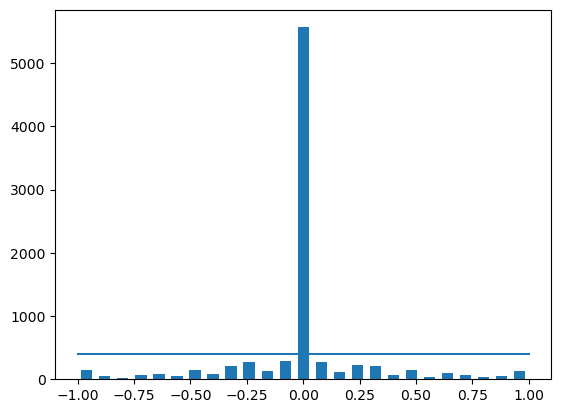

Total data:  8574
Remove:  5165
Remaining:  3409


In [4]:
datadir = "C:\\Users\\hkhat\\OneDrive\\Documents\\Harsh\\test"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_columns', 7)

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
centre = (bins[:-1] + bins[1:])*0.5
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

remove_list=[]
print('Total data: ', len(data))

for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if bins[j] <= data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print("Remove: ", len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print("Remaining: ", len(data))


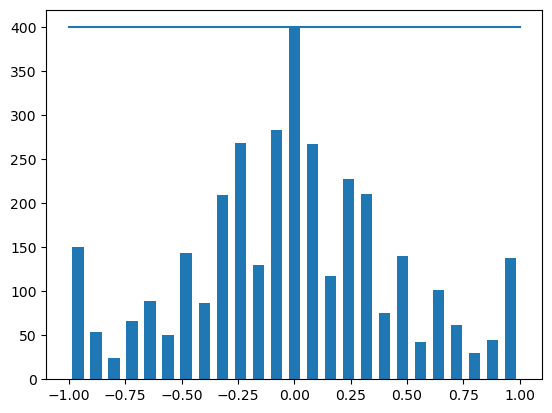

Training samples 8181
 Validation samples 2046


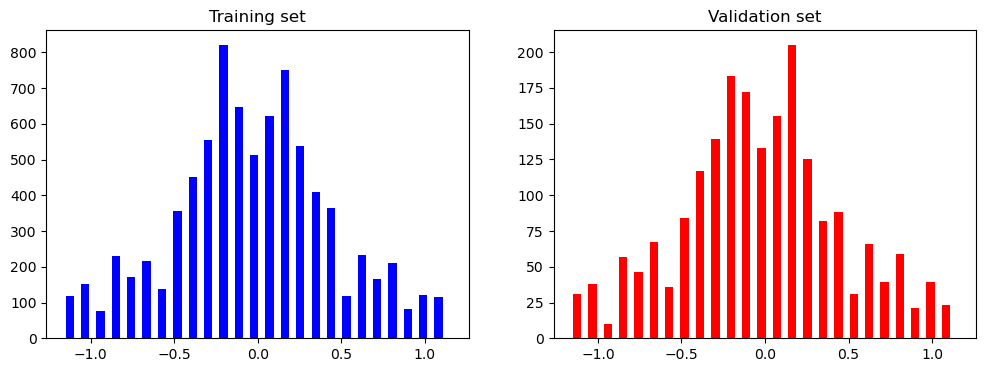

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hkhat\\OneDrive\\Documents\\Harsh\\test/IMG\\left_2024_01_19_01_35_51_775.jpg'

In [6]:

hist, bins = np.histogram(data['steering'], num_bins)
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

image_paths, steerings = load_steering_img(datadir+'/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print(f"Training samples {len(X_train)}\n Validation samples {len(X_valid)}")

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title("Validation set")
plt.show()

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = preprocess_img(image)
fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("Preprocessed image")
plt.show()


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")
plt.show()

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")
plt.show()

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
bright_image = img_random_brightness(original_image)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(bright_image)
axs[1].set_title("Bright Image")
plt.show()

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_angle = img_random_flip(original_image, steering_angle)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image - " + "Steering Angle: " + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title("Flipped Image"+ "Steering Angle: " + str(flipped_angle))
plt.show()



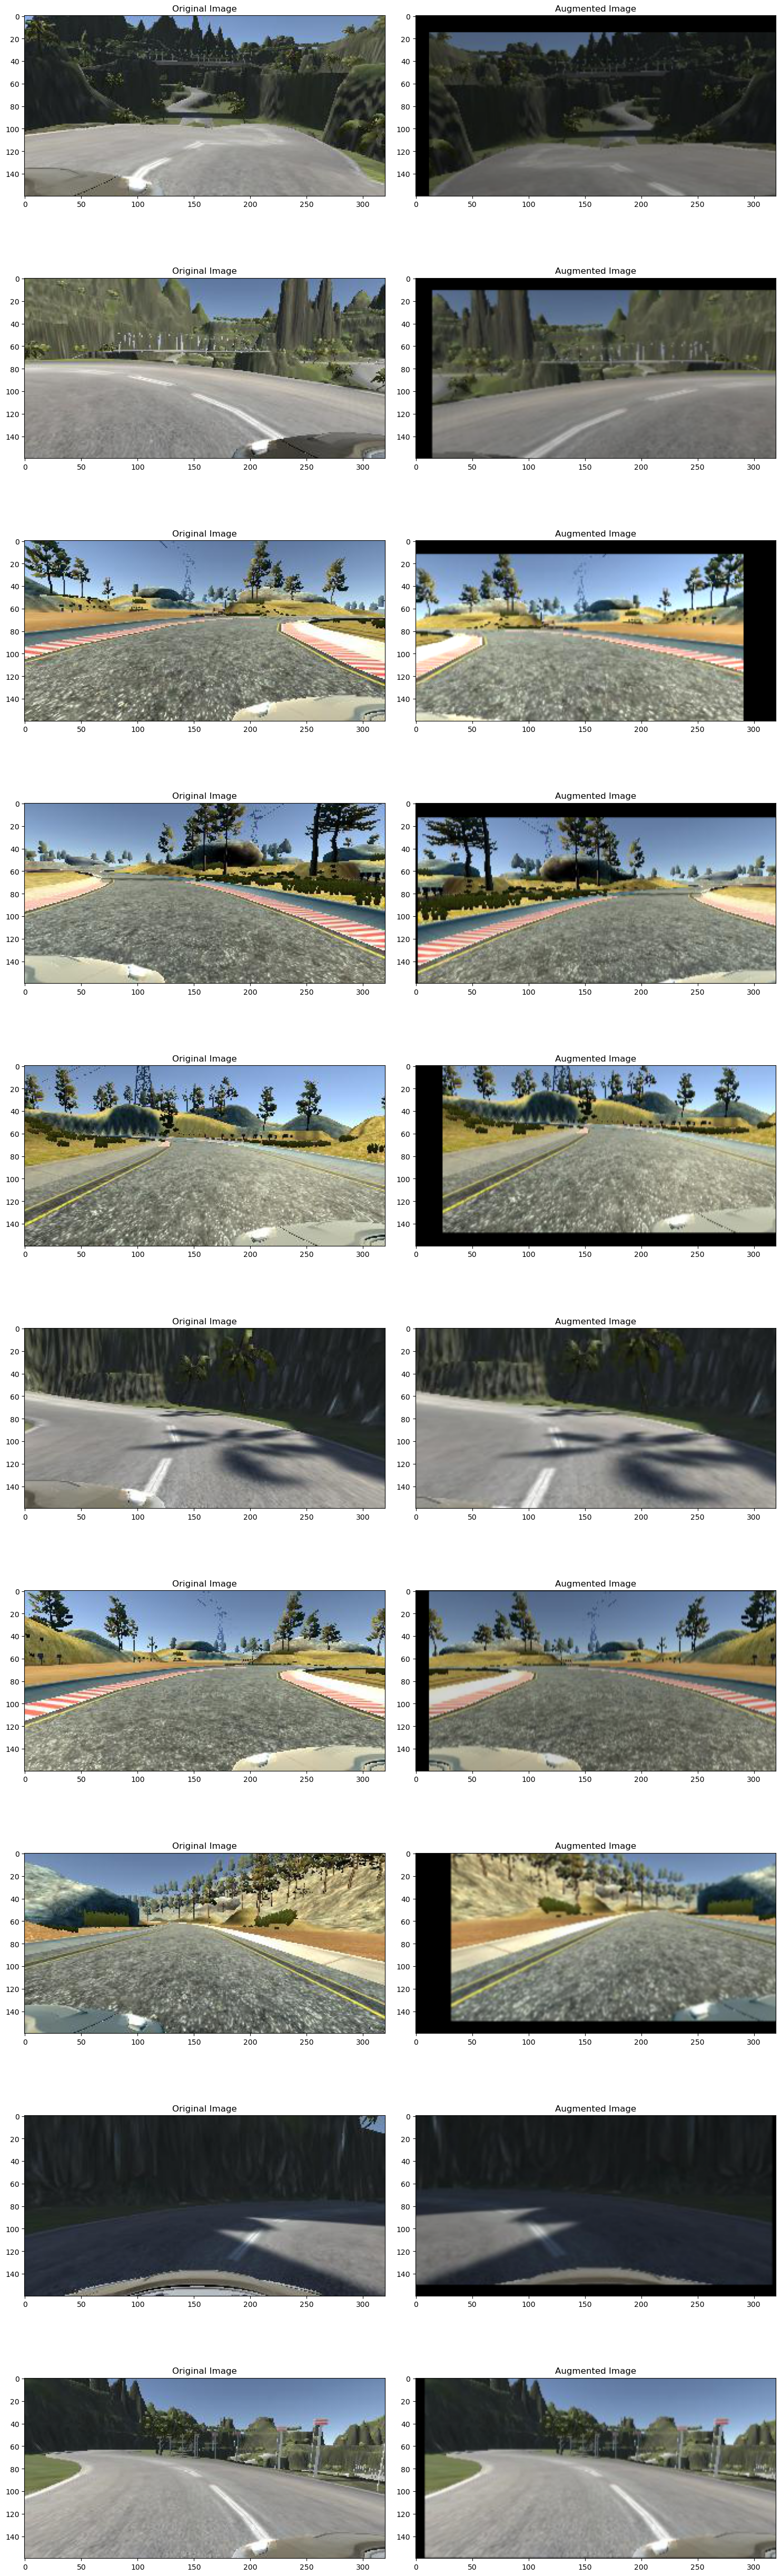

In [7]:
ncols = 2
nrows = 10
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
    rand_num = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[rand_num]
    random_steering = steerings[rand_num]
    original_image = mpimg.imread(random_image)
    augmented_image, steering_angle = random_augment(random_image, random_steering)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")
plt.show()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               

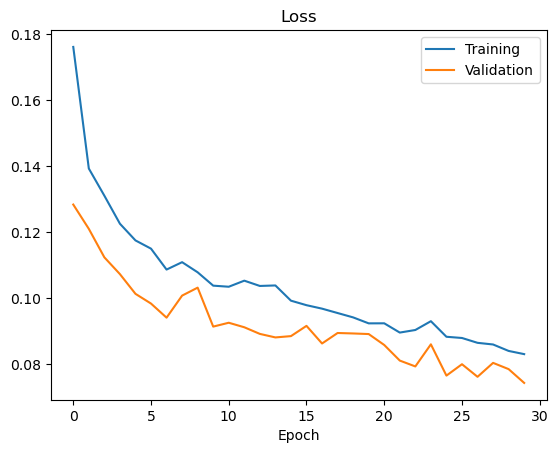

c:\Users\hkhat\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
model = nvidia_model()
print(model.summary())

history = model.fit(batch_generator(X_train, y_train, 200, 1), steps_per_epoch=100, epochs=30, validation_data=batch_generator(X_valid, y_valid, 200, 0), validation_steps=200, verbose=1, shuffle=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training", "Validation"])
plt.title('Loss')
plt.xlabel("Epoch")
plt.show()

model.save('model.h5')